In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

In [2]:
df = pd.read_csv('region-survey/MIDWEST.csv', header=[0,1])

In [3]:
loop_cols = ['Age', 
             'Education',
             'Gender', 
             'Household Income', 
             'Location (Census Region)', 
             'Which of the following states do you consider part of the Midwest? Please select all that apply. ',
             'How much, if at all, do you personally identify as a Midwesterner?']

In [4]:
for col in loop_cols: 
    df[col] = df[col].notnull()

In [5]:
df['edu_group'] = df['Education'].idxmax(axis=1)

In [6]:
df['age_group'] = df['Age'].idxmax(axis=1)
df['gender_group'] = df['Gender'].idxmax(axis=1)
df['income_group'] = df['Household Income'].idxmax(axis=1)
df['loc_group'] = df['Location (Census Region)'].idxmax(axis=1)

In [7]:
df['pid'] = df.index.values

In [8]:
state = 'Pennsylvania'
y = df[('Which of the following states do you consider part of the Midwest? Please select all that apply. ', state)]
x = df[['age_group', 'edu_group', 'gender_group', 'income_group', 'loc_group']]

In [9]:
for col in x.columns.get_level_values(0):
    x[col] = pd.Categorical(x[col])
    x[col + '_code'] = x[col].cat.codes

C:\Users\hello\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hello\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
regular_cols = ['age_group', 'edu_group', 'gender_group', 'income_group', 'loc_group']
code_cols = ['const','age_group_code', 'edu_group_code', 'gender_group_code', 'income_group_code', 'loc_group_code']

x = x.T.reset_index().T.reset_index()
x.columns = x.loc[0].values
x = x.drop([0,1]).reset_index(drop=True)
x = add_constant(x)

In [11]:
logr = Logit(y, x[code_cols].astype(int))
results = logr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.171206
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                             Logit Regression Results                                                                            
=================================================================================================================================================================================
Dep. Variable:     ('Which of the following states do you consider part of the Midwest? Please select all that apply. ', 'Pennsylvania')   No. Observations:                 2778
Model:                                                                                                                             Logit   Df Residuals:                     2772
Method:                                                                                                                              MLE   Df Model:                            5
Date:                                                                                                                   Wed, 14 Feb 2018   Pseudo R-squ.:                 0.03803
Time:                                                                                                                           00:00:56   Log-Likelihood:                -475.61
converged:                                                                                                                          True   LL-Null:                       -494.41
                                                                                                                                           LLR p-value:                 4.538e-07
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.3998      0.281     -8.528      0.000      -2.951      -1.848
age_group_code       -0.0884      0.068     -1.296      0.195      -0.222       0.045
edu_group_code        0.0559      0.058      0.969      0.333      -0.057       0.169
gender_group_code     0.0703      0.191      0.368      0.713      -0.304       0.445
income_group_code    -0.0461      0.066     -0.699      0.485      -0.175       0.083
loc_group_code       -0.2160      0.040     -5.426      0.000      -0.294      -0.138
=====================================================================================
"""

# Edu level

In [12]:
denom = df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().max()
midwest = pd.DataFrame(df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
midwest = midwest.rename(columns={0:'fivethirtyeight'})

In [13]:
edu_range = ['Less than high school degree', 
             'High school degree', 'Some college', 
             'Associate or bachelor degree', 'Graduate degree']
for edu in edu_range:
    denom = df.loc[df.loc[:, ('Education', edu)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum()['Iowa']
    temp = pd.DataFrame(df.loc[df.loc[:, ('Education', edu)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
    midwest = midwest.merge(temp, left_index=True, right_index=True).rename(columns={0:edu})

In [14]:
midwest = midwest.reset_index().rename(columns={'index':'state'})
midwest = pd.melt(midwest, id_vars='state')

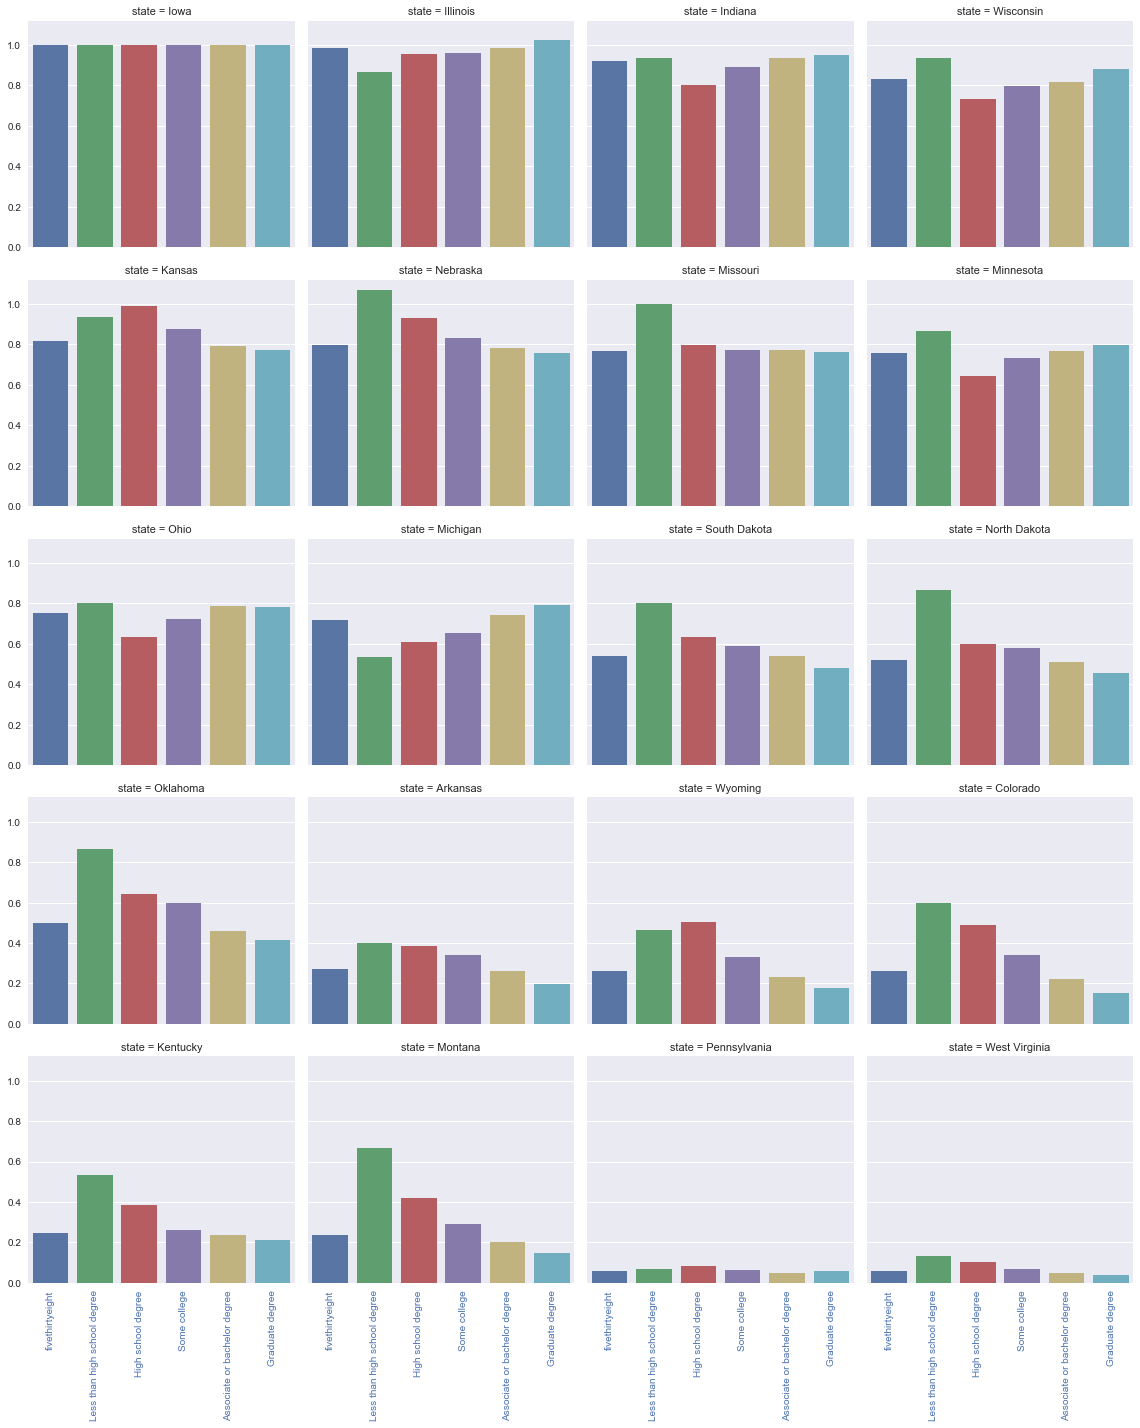

In [15]:
g = sns.factorplot(x='variable', y='value', col='state', kind='bar', col_wrap=4, data=midwest)
g.map(plt.xticks, rotation=90)
plt.show()

# Age

In [16]:
denom = df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sum()
midwest = pd.DataFrame(df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
midwest = midwest.rename(columns={0:'fivethirtyeight'})

In [17]:
age_range = ['> 60', '45-60', '30-44', '18-29']
for age in age_range:
    denom = df.loc[df.loc[:, ('Age', age)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sum()
    temp = pd.DataFrame(df.loc[df.loc[:, ('Age', age)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
    midwest = midwest.merge(temp, left_index=True, right_index=True).rename(columns={0:age})

In [18]:
midwest = midwest.reset_index().rename(columns={'index':'state'})
midwest = pd.melt(midwest, id_vars='state')

In [19]:
midwest.loc[midwest['state'] == 'Ohio']

,state,variable,value
8,Ohio,fivethirtyeight,0.066586
28,Ohio,> 60,0.067820
48,Ohio,45-60,0.064655
68,Ohio,30-44,0.066422
88,Ohio,18-29,0.067276


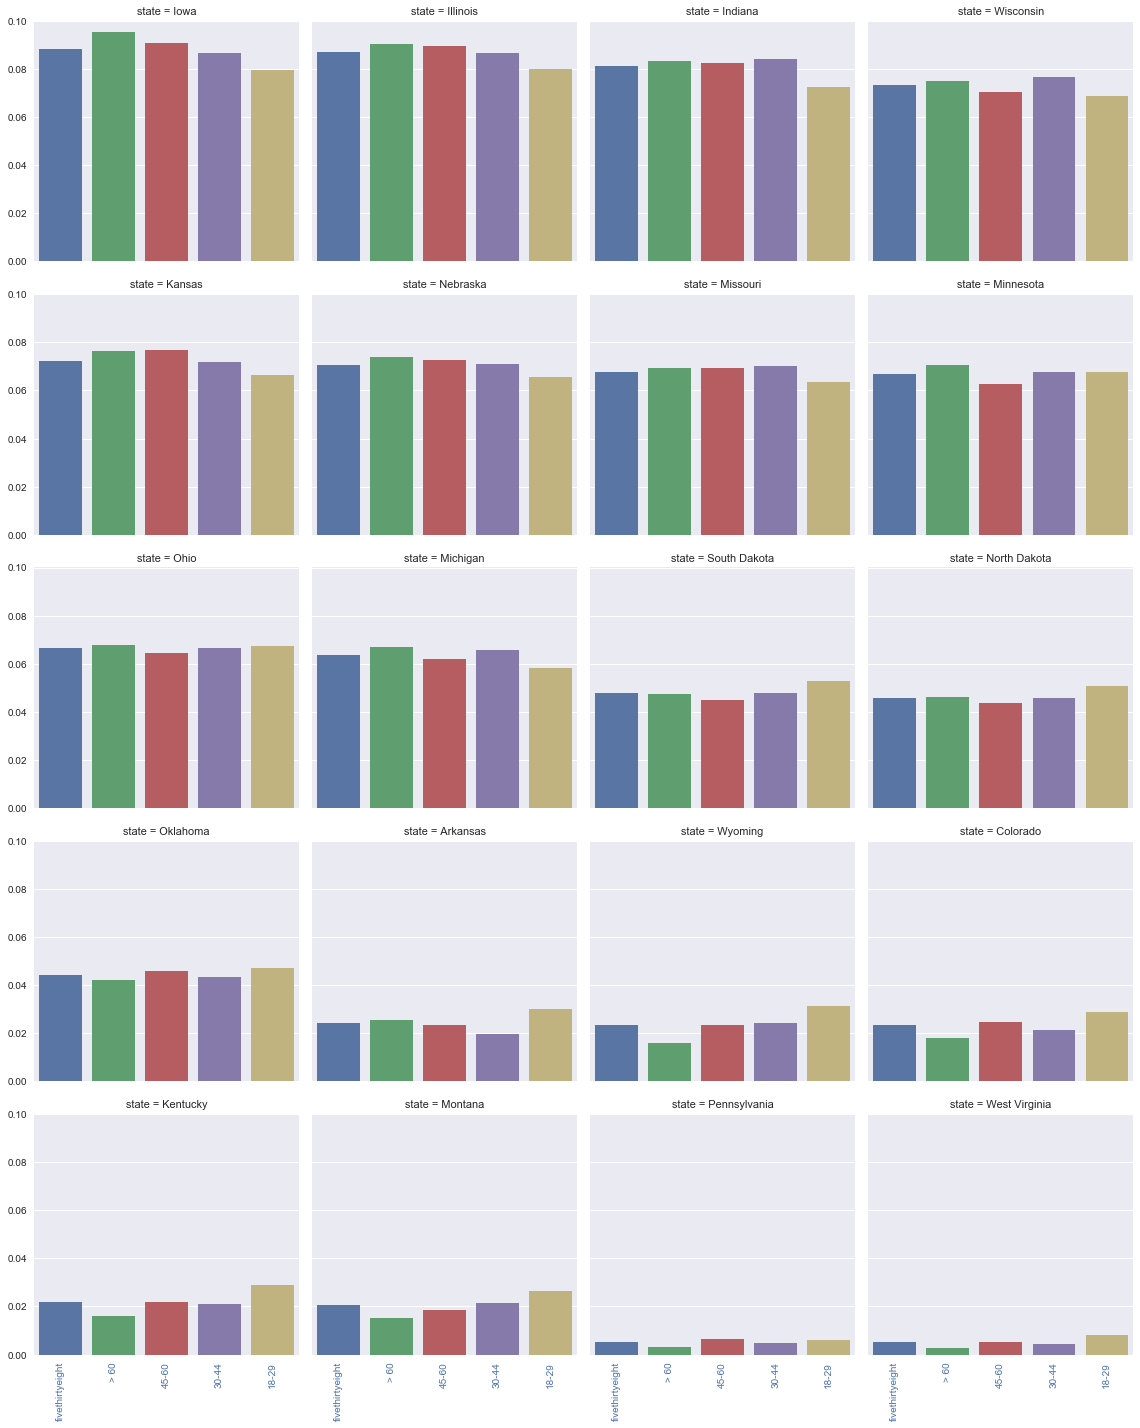

In [20]:
g = sns.factorplot(x='variable', y='value', col='state', 
                   col_wrap=4, kind='bar', data=midwest)
g.map(plt.xticks, rotation=90)
plt.show()

# Location (census)

In [21]:
denom = df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sum()
midwest = pd.DataFrame(df['Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
midwest = midwest.rename(columns={0:'fivethirtyeight'})

In [22]:
loca_range = ['New England', 'Middle Atlantic', 'East North Central',
       'West North Central', 'South Atlantic', 'East South Central',
       'West South Central', 'Mountain', 'Pacific']
for loca in loca_range:
    denom = df.loc[df.loc[:, ('Location (Census Region)', loca)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sum()
    temp = pd.DataFrame(df.loc[df.loc[:, ('Location (Census Region)', loca)], 
           'Which of the following states do you consider part of the Midwest? Please select all that apply. '].sum().sort_values(ascending=False)/denom)
    midwest = midwest.merge(temp, left_index=True, right_index=True).rename(columns={0:loca})

In [23]:
midwest = midwest.reset_index().rename(columns={'index':'state'})
midwest = pd.melt(midwest, id_vars='state')

In [24]:
midwest.loc[midwest['state'] == 'Ohio']

,state,variable,value
8,Ohio,fivethirtyeight,0.066586
28,Ohio,New England,0.074911
48,Ohio,Middle Atlantic,0.053385
68,Ohio,East North Central,0.091739
88,Ohio,West North Central,0.039803
108,Ohio,South Atlantic,0.058608
128,Ohio,East South Central,0.051613
148,Ohio,West South Central,0.055024
168,Ohio,Mountain,0.065884
188,Ohio,Pacific,0.066042


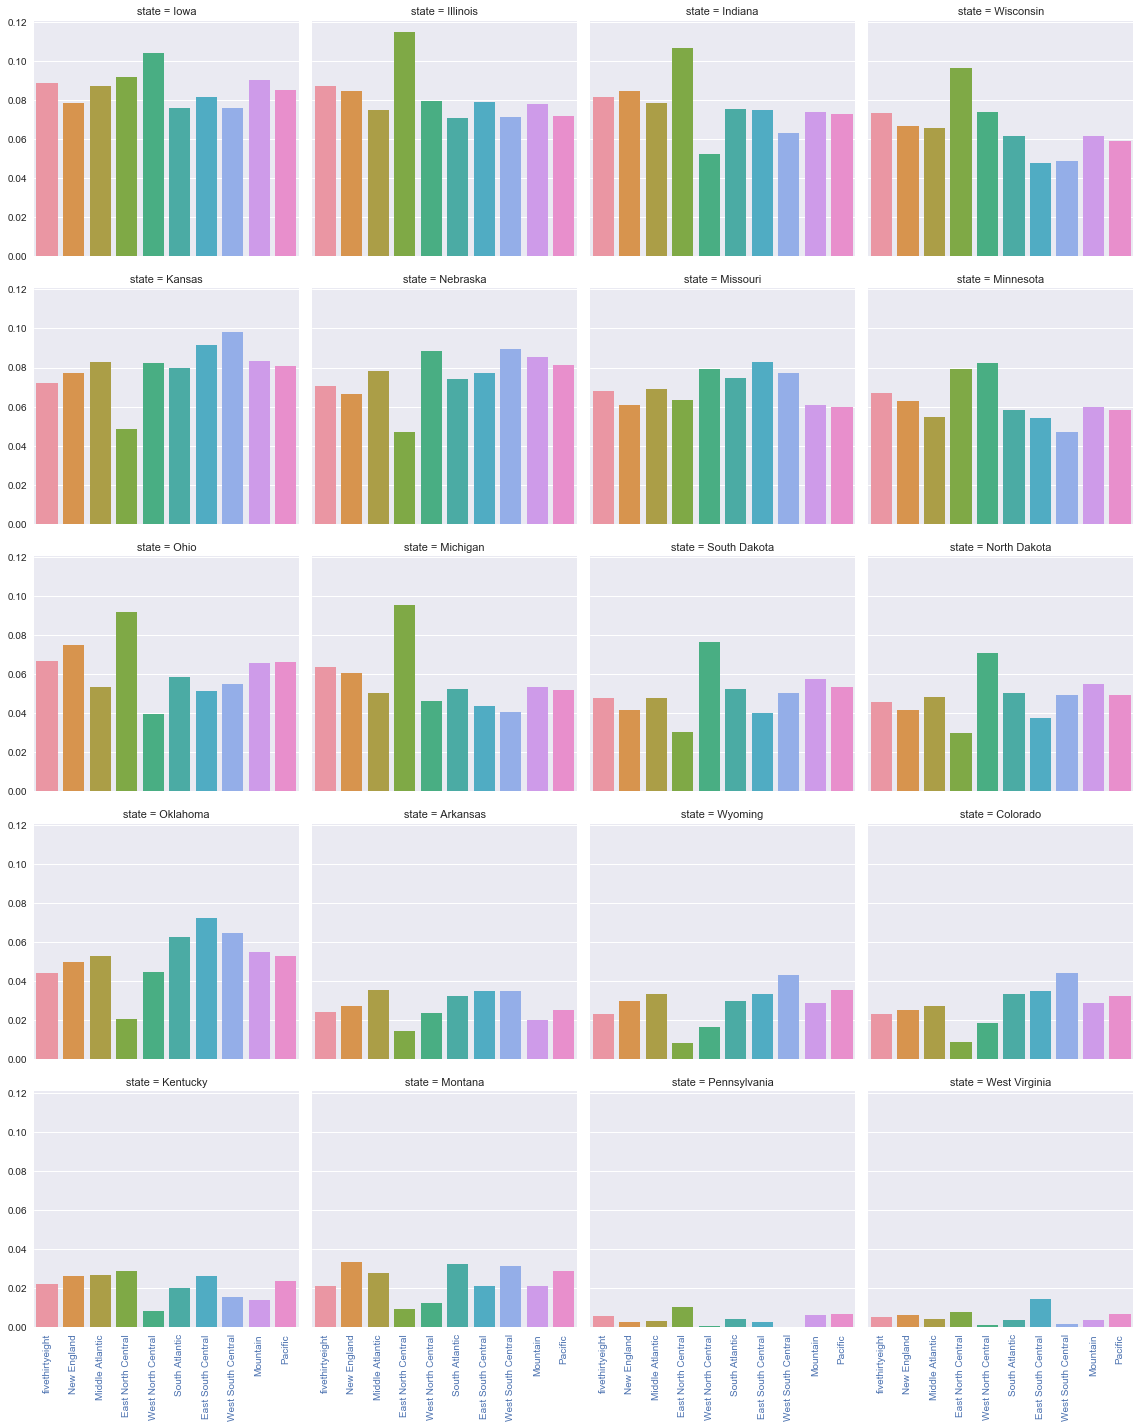

In [25]:
g = sns.factorplot(x='variable', y='value', col='state', 
                   col_wrap=4, kind='bar', data=midwest)
g.map(plt.xticks, rotation=90)
plt.show()